In [3]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks
from lmfit import Model

COLOR = 'w'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/30s/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/30s/reduced2/binned_data_a.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

np.append(flux, flux2, axis=0).shape

flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)
flare_mask[1] = np.delete(flare_mask[1],1)
flare_mask[2] = np.delete(flare_mask[2],1,axis=0)

parula = np.load('/Users/arcticfox/parula_colors.npy')#[np.linspace(0,210,len(times),dtype=int)]
distance = (9.72*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times-times[0], times2-times2[0]), 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.measure_FUV130()
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion=ion)

## Plot Si III and C III flares

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


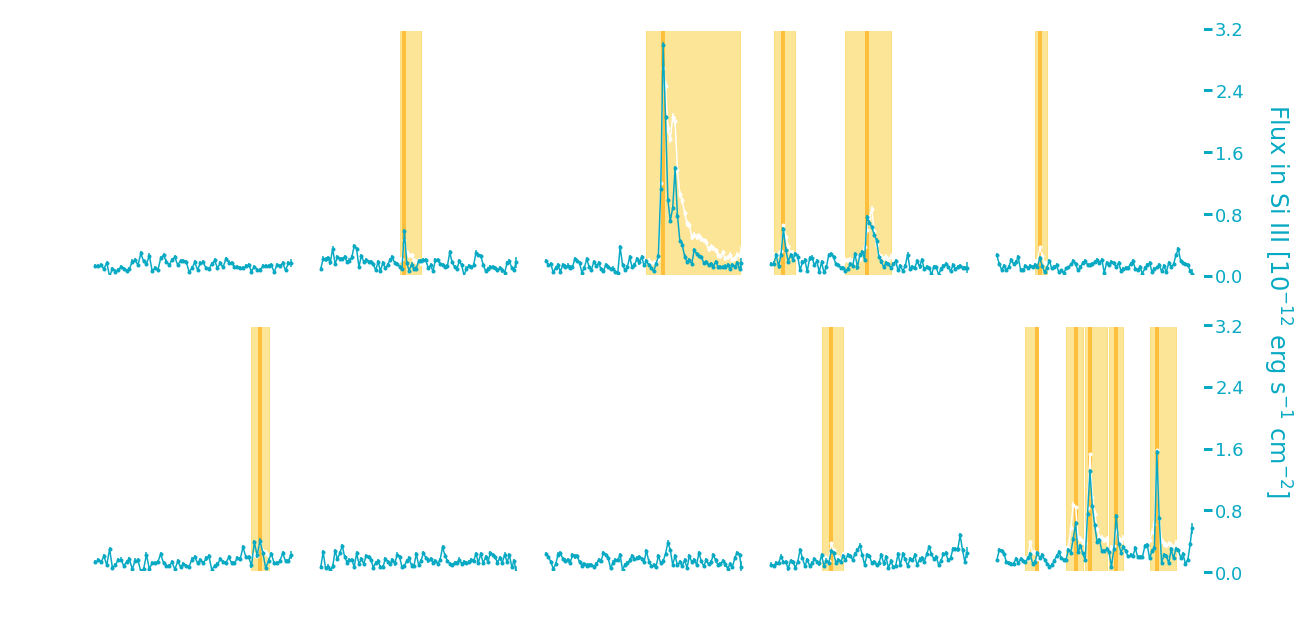

In [139]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
ax = axes.reshape(-1)
fig.set_facecolor('w')

d = .025
c=100

mcolor = COLOR
scolor = parula[100]

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].errorbar(fwc.time[q].value, 
                 fwc.width_table['CIII'][q].value, 
                 yerr=fwc.error_table['CIII'][q].value,
                 color=mcolor, marker='.')
    
    ax2 = ax[j].twinx()
    
    ax2.errorbar(fwc.time[q].value, 
                 fwc.width_table['SiIII'][q].value, 
                 yerr=fwc.error_table['SiIII'][q].value/10,
                 color=scolor, marker='.')
    
    if j in flare_mask[1]:
        inds = np.where(np.array(flare_mask[1])==j)[0]

        for n in inds:
            m = flare_mask[2][n] != 0
            ax[j].axvspan(fwc.time[m][0].value, 
                          fwc.time[m][-1].value, 0, 1,
                          color=parula[225], alpha=0.5)
            
            argmax = np.argmax(fwc.width_table['SiIII'][m])
            ax[j].vlines(fwc.time[m][argmax].value,
                         0, 1, color=parula[215], lw=4)

            c += 15
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax[j].set_yticks([])
        #ax2.set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        

    if j == 2:
        ax[j].set_title('Visit 1')#, fontsize=)
    if j == 7:
        ax[j].set_title('Visit 2')
        ax[j].set_xlabel('Time - $T_0$ [s]', fontsize=24)

    if j < 5:
        ax[j].set_xticklabels([])

    if j == 0 or j == 5:
        yticks = np.arange(0.4e-11,6e-11,1e-11)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(np.round(yticks/1e-11, 2))
    if j < 5:
        ax[j].set_xticklabels([])
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    else:
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    if j == 9 or j == 4:
        yticks = np.arange(0.2e-13, 3.5e-12,8e-13)
        ax2.set_yticks(yticks)
        ax2.tick_params(axis='y', colors=scolor)
        ax2.set_yticklabels(np.round(yticks/1e-12, 1), color=scolor)
        
    if j == 5:
        ax[j].set_ylabel('Flux in C III [$10^{-11}$ erg s$^{-1}$ cm$^{-2}$]', 
                         fontsize=24, y=1.1)
    if j == 9:
        ax[j].set_ylabel('Flux in Si III [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]\n\n\n\n\n\n\n\n\n\n', 
                       fontsize=24, y=1.1, color=scolor, rotation=270)
    ax[j].set_rasterized(True)
        
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/flares_dark.png',
            rasterize=True, bbox_inches='tight', dpi=300, transparent=True)

In [6]:
f = np.zeros(len(fwc.time))
e = np.zeros(len(fwc.time))
for i in range(len(fwc.time)):
    f[i] = np.trapz(fwc.flux[i]*fwc.flux_units, x=fwc.wavelength[i]*units.AA).value
    e[i] = np.trapz(fwc.flux_err[i]**2*fwc.flux_units,x=fwc.wavelength[i]*units.AA).value
    e[i] = np.sqrt(e[i]/len(fwc.flux_err[i]))

In [7]:
len(flare_mask[1])
letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M']

In [8]:
parula[225]

'#fdcc30'

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


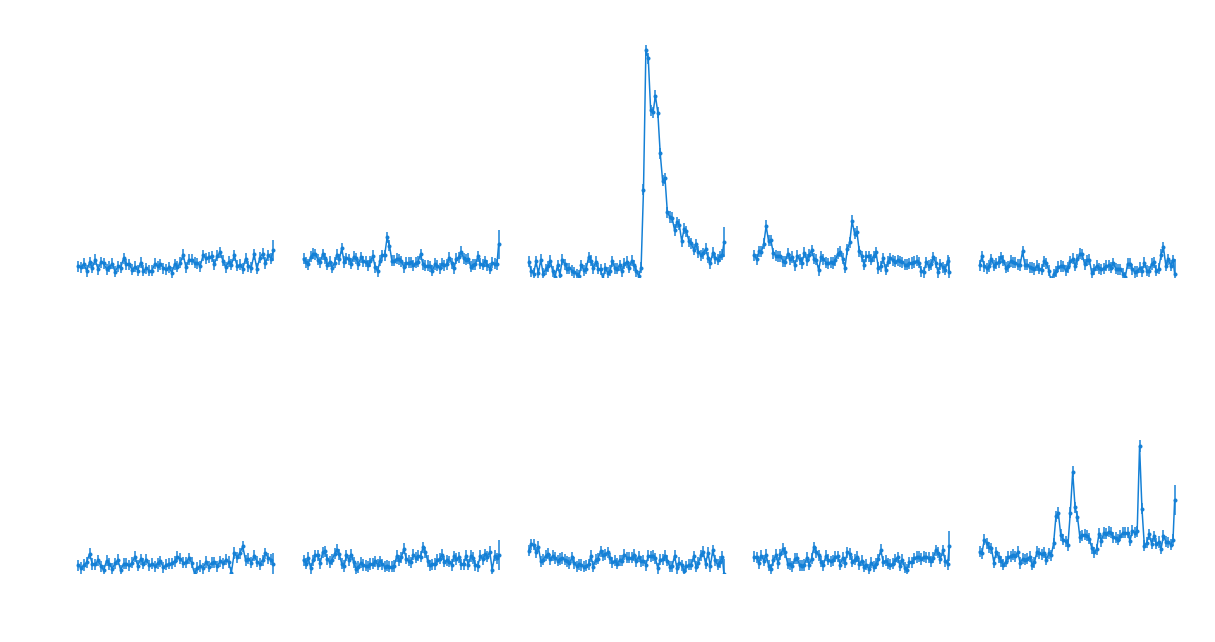

In [10]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
ax = axes.reshape(-1)
fig.set_facecolor('w')
amps, tpeaks = np.array([]), np.array([])

d = .025
c=100

mcolor = parula[60]#COLOR
scolor = parula[60]
count = 0
label=False

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].errorbar(fwc.time[q].value, 
                 f[q]/1e-12,
                 yerr=e[q]/1e-12,
                 color=mcolor, marker='.')
    if label:
        if j in flare_mask[1]:
            inds = np.where(np.array(flare_mask[1])==j)[0]

            for n in inds:
                m = flare_mask[2][n] != 0
                ax[j].axvspan(fwc.time[m][0].value, 
                              fwc.time[m][-1].value, 0, 1,
                              color=parula[225], alpha=0.5)

                amp = np.where((fwc.time[q]>=fwc.time[m][0]) & 
                               (fwc.time[q]<=fwc.time[m][-1]))[0]
                amps=np.append(amps,f[q][amp][np.argmax(f[q][amp])]/1e-12)

                argmax = np.argmax(fwc.width_table['SiIII'][m])
                tpeaks=np.append(tpeaks,fwc.time[m][argmax].value)
                ax[j].vlines(fwc.time[m][argmax].value,
                             0, 10, color=parula[215], lw=4)

                if letters[n] == 'B':
                    ax[j].text(s='Flare {}'.format(letters[n]), 
                               x=fwc.time[m][argmax].value, y=4.2,
                               fontsize=18)
                elif letters[n] == 'I':
                    ax[j].text(s='Flare {}'.format(letters[n]), 
                               x=fwc.time[m][argmax].value-20, y=3.4, rotation=270,
                               fontsize=18)
                else:
                    ax[j].text(s='Flare {}'.format(letters[n]), 
                               x=fwc.time[m][argmax].value+50, y=3.4,
                               fontsize=18, rotation=270)


                c += 15
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        #ax2.set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        

    if j == 2:
        ax[j].set_title('Visit 1', fontsize=24)
    if j == 7:
        ax[j].set_title('Visit 2', fontsize=24)
        ax[j].set_xlabel('Time from Exposure Start [s]', fontsize=24)

    if j < 5:
        ax[j].set_xticklabels([])
    ax[j].set_ylim(0.9,4.5)

        
    if j == 5:
        ax[j].set_ylabel('Flux [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]', 
                         fontsize=24, y=1.1)

    ax[j].set_rasterized(True)
        
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/flux_unlabeled.png',
            rasterize=True, bbox_inches='tight', dpi=300, transparent=True)

In [30]:
flare_params=np.zeros((len(amps),2))
flare_params[:,0]=tpeaks
flare_params[:,1]=amps
np.save('flare_peaks_amps.npy',flare_params)

In [94]:
qmask = np.nansum(flare_mask[2],axis=0) == 0

for i in range(len(flare_mask[2])):
    
    fmask = flare_mask[2][i] > 0
    energy, duration = fwc.measure_flare_params(qmask=qmask,
                                                fmask=fmask,
                                                d=distance,
                                                flux=f)
    Fq = np.nanmedian(f[qmask]/10**-13)*units.erg/units.s/units.cm**2
    Ff = (f[fmask]/10**-13)*units.erg/units.s/units.cm**2
    energy = np.trapz(Ff-Fq, x=fwc.time[fmask]) * 4 * np.pi * distance**2
    dur = np.trapz((Ff-Fq)/Fq, x=fwc.time[fmask])
    
    print(energy*10e-13, dur)

3.7596754287355347e+30 erg 29.352123365878384 s
9.459955426684652e+31 erg 738.5472070208607 s
7.723615907166813e+30 erg 60.29896230006933 s
1.0770878149658881e+31 erg 84.0892120078459 s
3.887545021205403e+29 erg 3.0350412745922686 s
1.4569704180589275e+30 erg 11.374698763739813 s
1.0300497229805887e+30 erg 8.04169059670226 s
1.1620953283917872e+30 erg 9.07258248442437 s
8.655609375569604e+30 erg 67.57511892031037 s
1.7585913138452138e+31 erg 137.29480156617484 s
5.629950108517327e+30 erg 43.95352557987131 s
1.821432055233202e+31 erg 142.2008346229801 s


# Fitting the flares

In [67]:
from scipy.interpolate import interp1d
import corner

100%|██████████| 3000/3000 [00:22<00:00, 131.41it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [158.46581764  95.42449482 148.2702235   61.06912434  60.52396099
 103.27757813]


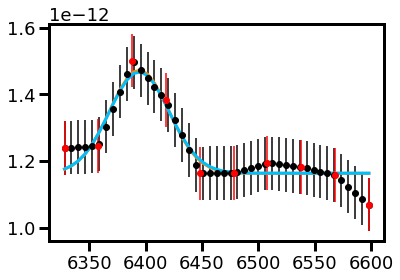

  0%|          | 0/3000 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:27<00:00, 107.48it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 16 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [239.42632198 336.23893334 290.38558072 295.96318561 305.59132492
 271.36613297 286.78090397 344.28571129 304.87720988 303.62910777
 299.23147247 294.36904365 261.80282261 332.84531332 307.9783489
 307.11380212]


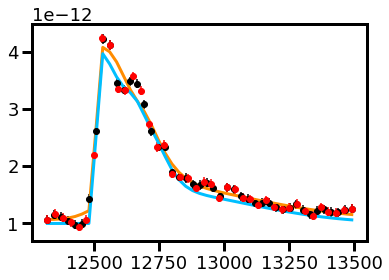

100%|██████████| 3000/3000 [00:23<00:00, 126.15it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [109.35186025  95.72852656 110.13530505  77.65640801  79.58680857
  99.92828088]


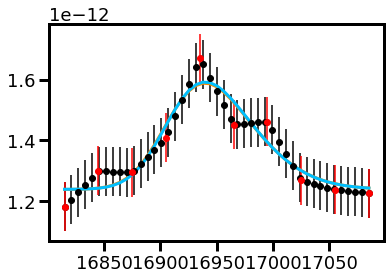

100%|██████████| 3000/3000 [00:22<00:00, 131.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [123.38485183 114.58958809 118.26588673  65.34943119  66.48113839
  90.86388673]


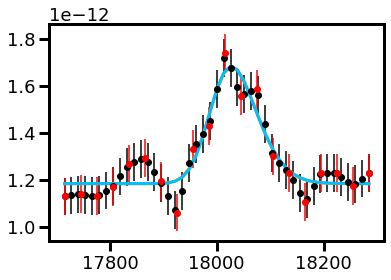

100%|██████████| 3000/3000 [00:21<00:00, 137.30it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [109.61566201 100.67017205 113.74551905  52.27746984  62.37157883
 156.93578893]


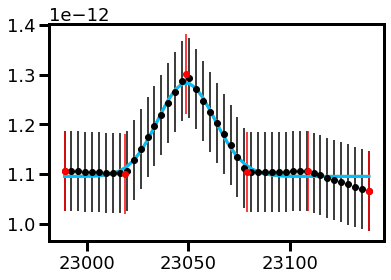

100%|██████████| 3000/3000 [00:21<00:00, 142.56it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [253.13326723  99.45860777 268.1693071   74.00177795  82.18473576
  72.02533462]


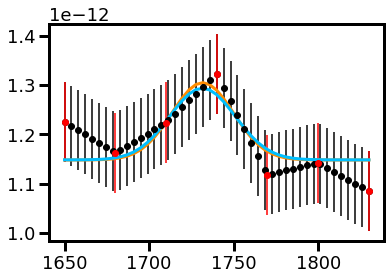

100%|██████████| 3000/3000 [00:21<00:00, 138.64it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [64.58672804 66.75435586 83.01121635 60.91345192 64.40599605 92.94787294]


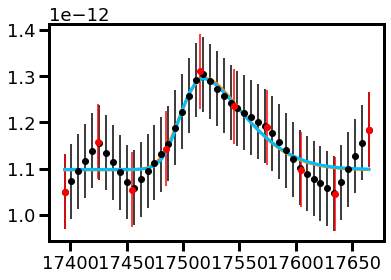

100%|██████████| 3000/3000 [00:14<00:00, 207.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [255.37785262 273.50221752 191.46000287 202.78112919 172.01785924
 146.89968579]


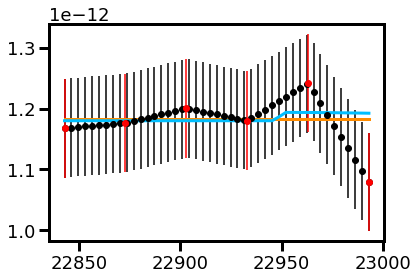

100%|██████████| 3000/3000 [00:22<00:00, 131.89it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [53.9742346  58.75163651 58.39835872 55.98199741 56.23093165 87.00915882]


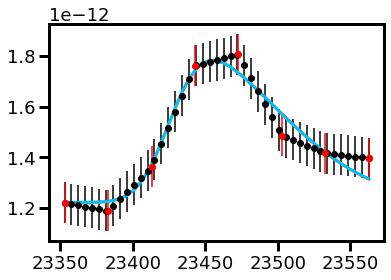

100%|██████████| 3000/3000 [00:22<00:00, 130.53it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [56.82265533 54.73983382 55.35862734 51.28004257 52.76783499 89.7890113 ]


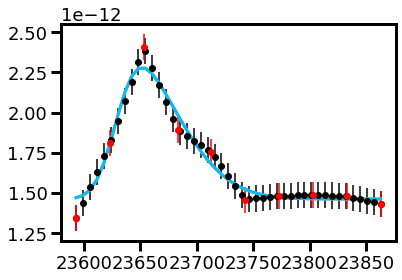

  0%|          | 0/3000 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:20<00:00, 144.69it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [ 62.86291671 107.87471776  83.06117312  66.44642213 106.94300809
  96.60518561]


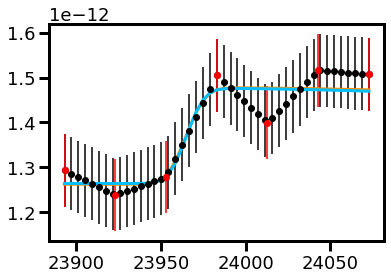

100%|██████████| 3000/3000 [00:25<00:00, 116.66it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [88.36495618 87.88290966 86.66867437 59.87038704 62.99612728 75.03644031]


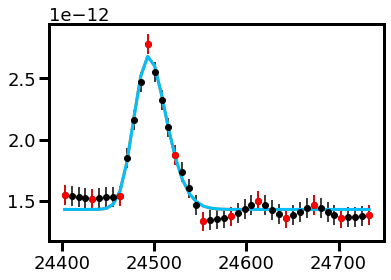

In [127]:
scale=1e-12

emcee_out = []

emcee_kws = dict(steps=3000, burn=500, is_weighted=False,
                 progress=True)

for i in range(len(flare_mask[-1])):
    m = flare_mask[-1][i] > 0
    x = fwc.time[m] + 0.0
    y = f[m] + 0.0
    yerr = e[m] + 0.0
    
    upsample = np.linspace(x.min(), x.max(),45)
    finterp = interp1d(x,y)
    einterp = interp1d(x,yerr)
    
    plt.errorbar(upsample,
                 finterp(upsample), 
                 yerr=einterp(upsample),
                 color='k', marker='o', linestyle='')
    plt.errorbar(x,
                 y,
                 yerr=yerr,
                 color='red', marker='o', linestyle='')
    
    t0,amp=multi_peaks(x,y)
    
    
    if i == 1:
        eta = t0
        omega = np.full(len(t0), 150)
        alpha = np.full(len(t0), 50)
        
    else:
        eta = t0[:1]
        omega = np.full(len(eta), 150)
        alpha = np.full(len(eta), 50)
        
    out = fwc.fit_flare(ion='CIII', mask=m,
                        model='skewed gaussian',
                        eta=eta, omega=omega, alpha=alpha,
                        x=upsample.value, 
                        y=finterp(upsample)/scale, 
                        yerr=einterp(upsample)/scale)
    
    emcee_params = out[-1].params.copy()
    emcee_params.add('__lnsigma', value=np.log(0.1), 
                     min=np.log(0.001), max=np.log(2.0))
    
    result_emcee = out[-2].fit(data=finterp(upsample)/scale, 
                               x=upsample.value, 
                               params=emcee_params, method='emcee',
                               nan_policy='omit', fit_kws=emcee_kws)
       
    plt.plot(upsample.value, out[-1].best_fit*scale, color='darkorange', lw=3)
    plt.plot(upsample.value, result_emcee.best_fit*scale, color='deepskyblue', lw=3)
    plt.show()
    
    emcee_out.append([x,y/scale,yerr/scale,out,upsample,result_emcee])

In [133]:
def build_emcee_fits(x, flatchain, percentile):
    med_model = Model(skewed_gaussian, prefix='f{0:02d}_'.format(0))
    
    for i in range(1,3):
        med_model += Model(skewed_gaussian, prefix='f{0:02d}_'.format(i))
    pars = med_model.make_params()

    for name in result_emcee.var_names[:-1]:
        pars[name].set(value=np.percentile(flatchain[name], percentile))

    gg = med_model.eval(pars,x=x.value)
    return gg

In [135]:
bef = build_emcee_fits(emcee_out[i][4], emcee_out[i][-1].flatchain, 50)

<ErrorbarContainer object of 3 artists>

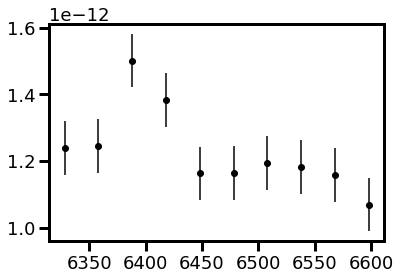

In [116]:
for i in range(1):
    plt.errorbar(emcee_out[i][0], emcee_out[i][1]*scale,
                 yerr= emcee_out[i][2]*scale, c='k', marker='o', linestyle='')

In [74]:
med = []
for name in result_emcee.var_names:
    med.append(np.percentile(result_emcee.flatchain[name], 50))

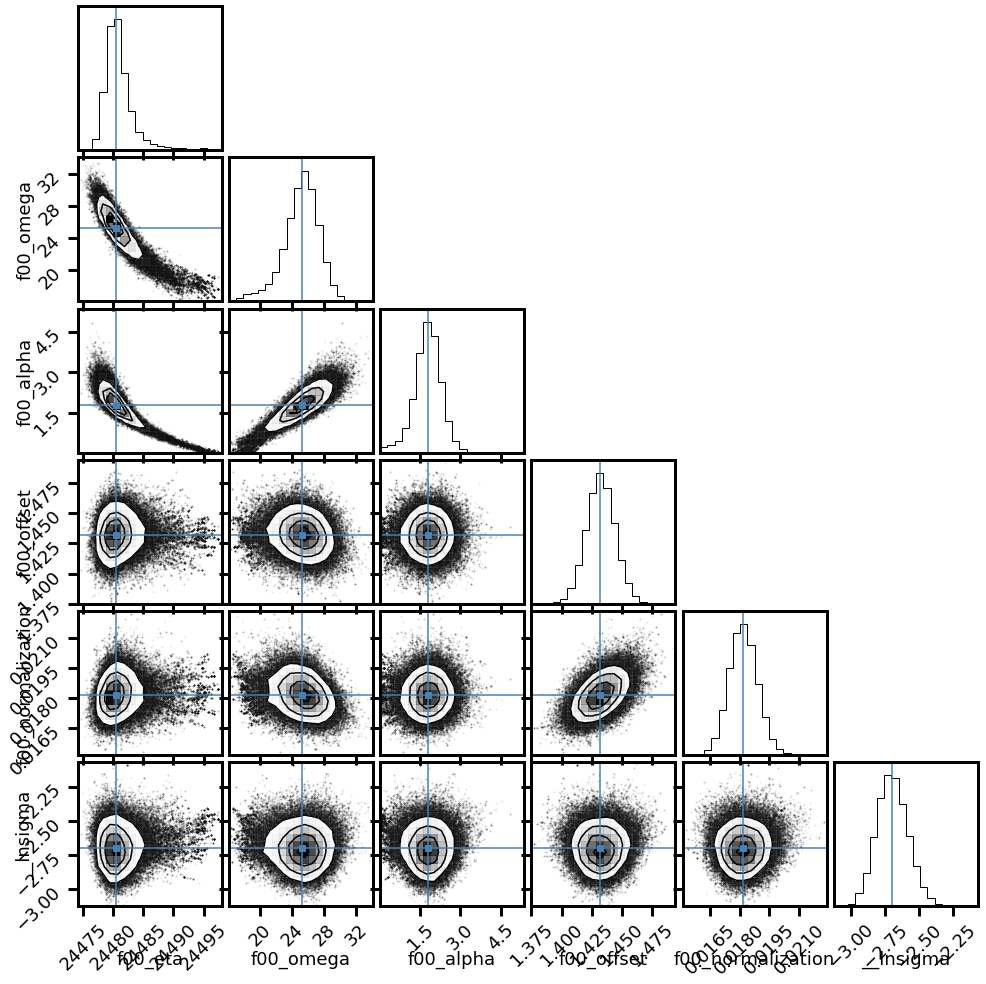

In [151]:
c = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                  truths=list(result_emcee.params.valuesdict().values()))